In [1]:
!ls models data

data:
dataset-01-08-2018.zip	yahoo.answers.tar.gz

models:
yahooanswers


# Piece classification

Marcelo H. P. Ferreira

## Data

Labelized by challenger

|column|value|
|------|-----|
|document_id|Document id in database|
|first_page|Only the text content of first page for each document|
|label|Label of especialists|
|pages|All pages of document|
|text|The valid content for classification|

Dataset's proportions:

* 70% train
* 20% validation
* 10% test

## Configuração

 
* pip install sklearn;
* pip install seaborn;
* pip install matplotlib;
* pip install pandas;
* pip install numpy;
* pip install jupyter;
* pip install joblib;
* pip install tensorflow-gpu;
* pip install keras;
* pip install nltk;

# Imports

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import spacy as sp
import numpy as np
# import paramiko
import os
import multiprocessing
import tensorflow as tf
import joblib
import ipywidgets as widgets
import zipfile
import nltk
import collections

from tqdm import tqdm
from IPython.display import display, HTML

from keras.utils import plot_model
from keras import models
from keras.models import Sequential, Model
from keras.engine import Input
from keras.layers import (
    Embedding, BatchNormalization,
    LSTM, SimpleRNN, GRU, RNN, CuDNNLSTM,
    Conv1D, MaxPooling1D,
    Bidirectional, Concatenate, merge,
    Dense, Flatten, Dropout, Activation, Lambda, Reshape
)
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping, TerminateOnNaN, ModelCheckpoint
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix
)
from sklearn.svm import SVC

Using TensorFlow backend.


In [3]:
plt.rcParams['figure.figsize'] = [15, 10]

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

# Report

Plot a normalized matrix

In [5]:
def report(y, y_hat, labelizer=None, history=None, classes=None):
    if labelizer is None and classes is None:
        raise Exception('Labelizer or classes should be passed')
        
    if labelizer:
        y, y_hat = labelizer.inverse_transform(y), labelizer.inverse_transform(y_hat)
        classes = labelizer.classes_
    
    cm = confusion_matrix(y, y_hat)
    ncm = cm / cm.max(axis=1)[:, None]

    print(classification_report(y, y_hat, target_names=classes))
    print('Accuracy: ', accuracy_score(y, y_hat))

    
    plt.title('confusion matrix')
    heatmap = sns.heatmap(
        pd.DataFrame(
            ncm, 
            index=classes,
            columns=classes),
        annot=cm,
        fmt='d',
        cmap=sns.cubehelix_palette(light=1, as_cmap=True)
    )
    plt.show()
    if history:
        plt.subplot(2, 1, 1)
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        
        plt.grid(True)
        plt.xticks(range(1, len(history.history['val_acc'])+1))

        plt.subplot(2, 1, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        
        plt.grid(True)
        plt.xticks(range(1, len(history.history['val_acc'])+1))
        
        plt.show()
        print(
            np.argmax(history.history['val_acc']),
            history.history['acc'],
            history.history['val_acc'],
            history.history['loss'],
            history.history['val_loss'],
        )

# Model persistence

Assure the model dir exist

In [6]:
# Create dir to store models
model_path = '/home/seth/marcelo/tcc/models'

if not os.path.exists(model_path):
    os.mkdir(model_path)

In [7]:
def get_checkpoint(model_name, prev_callbacks=None):
    if not prev_callbacks:
        prev_callbacks = []
    file_path = os.path.join(model_path, model_name)
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', mode='max', save_best_only=True, verbose=1)
    prev_callbacks.append(checkpoint)
    return prev_callbacks

In [8]:
def load_model(model_name):
    file_path = os.path.join(model_path, model_name + '.h5')
    return models.load_model(file_path)

In [9]:
def save_model(model, model_name=None):
    if model_name == None:
        model_name = 'model-'+ '-'.join([x['class_name'][:3] for x in model.get_config()]) + '.h5'
        model_name = model_name.lower()
    path = os.path.join(model_path, model_name)
    model.save(path)

In [10]:
def save_pickle(model, model_name=None):
    name = '{}.pkl'.format(model_name)
    file_path = os.path.join(model_path, name)
    
    joblib.dump(model, file_path)

In [11]:
def load_pickle(model_name=None):
    name = '{}.pkl'.format(model_name)
    file_path = os.path.join(model_path, name)
    return joblib.load(file_path)

# Network Setup
## Params

In [12]:
# Macro feactures
MAX_FEATURES = 70000  # Size of vocabulary
EMBEDDING_DIM = MAX_FEATURES  # Size of vocabulary
SEQUENCE_LEN = 1000 # Size of input arrays
PSEQUENCE_LEN = 1000
BATCH_SIZE = 256  # Base multiplier to batch train data
NB_CLASS = 6 #train.label.unique().size  # Number of output classes
UNITS = 100  # Number of output cells for Recurrent Models
EMBEDDING_OUT = 100  # Output dim of embedding
EPOCHS = 30  # Number of rounds

## Callbacks

In [13]:
# Define callbacks
early_stop = EarlyStopping(patience=5, verbose=1, restore_best_weights=True, monitor='val_acc')
# board = TensorBoard(log_dir='./log')
# check_point = ModelCheckpoint('models/', monitor='val_acc')
# callbacks = []# check_point, ] #early_stop, ]

# Dataset
## Loading

In [14]:
def parse_labels(label):
    if label == "Desp.":
        return "Despacho"
    if label == "Sent.":
        return "Sentença"
    return label


In [15]:
with zipfile.ZipFile('data/dataset-01-08-2018.zip', 'r') as zip_file:
#     train = pd.read_csv(zip_file.open('train-24-08-2018.csv'))
#     validation = pd.read_csv(zip_file.open('validation-24-08-2018.csv'))
#     test = pd.read_csv(zip_file.open('test-24-08-2018.csv'))
#     print(zip_file.filelist)
    train = pd.read_csv(zip_file.open('train-01-08-2018-wo-duplicates.csv'))
    validation = pd.read_csv(zip_file.open('validation-01-08-2018-wo-duplicates.csv'))
    test = pd.read_csv(zip_file.open('test-01-08-2018-wo-duplicates.csv'))
    
    # Remove documents not used
    train = train[(train.label != 'D. Agrav') & (train.label != 'P. Agrav')]
    test = test[(test.label != 'D. Agrav') & (test.label != 'P. Agrav')]
    validation = validation[(validation.label != 'D. Agrav') & (validation.label != 'P. Agrav')]

    train['label'] = train.label.apply(parse_labels)
    validation['label'] = validation.label.apply(parse_labels)
    test['label'] = test.label.apply(parse_labels)

## Example of loaded data

In [16]:
train.iloc[0]

body            (e-STJ Fl.279)\n DEFENSORIA PÚBLICA DA UNIÃO N...
label                                                         ARE
document_id                                                 10632
source_pages                                               second
pages           [{'index': 0, 'body': '(e-STJ Fl.278)\n DEFENS...
path            /norm/339/ARE_1066313/ARE_1066313_312418603_14...
first_page      (e-STJ Fl.278)\n DEFENSORIA PÚBLICA DA UNIÃO N...
page_hash       ea658bef7aa8d22c3dbacc403dd92c0c43e031ce5ec058...
Name: 0, dtype: object

In [17]:
# table
labels_index = train.label.value_counts().index.sort_values()

label_train = train.label.value_counts()[labels_index]
label_validation = validation.label.value_counts()[labels_index]
label_test = test.label.value_counts()[labels_index]

labels = (test.label.value_counts() + validation.label.value_counts() + train.label.value_counts())[labels_index]

label_description = "<table><tr><th>Label</th><th>Train</th><th>Validation</th><th>Test</th><th>Total</th></tr>"

for label_counts in zip(labels_index, label_train, label_validation, label_test, labels):
    label_description += """
    <tr>
        <td>{}</td><td>{}</td><td>{}</td><td>{}</td><td>{}</td>
    </tr>""".format(*label_counts) 

label_description += "<tr><td colspan=3>Total</td><td>{}</td></tr></table>".format(labels.sum())
display(HTML(label_description))

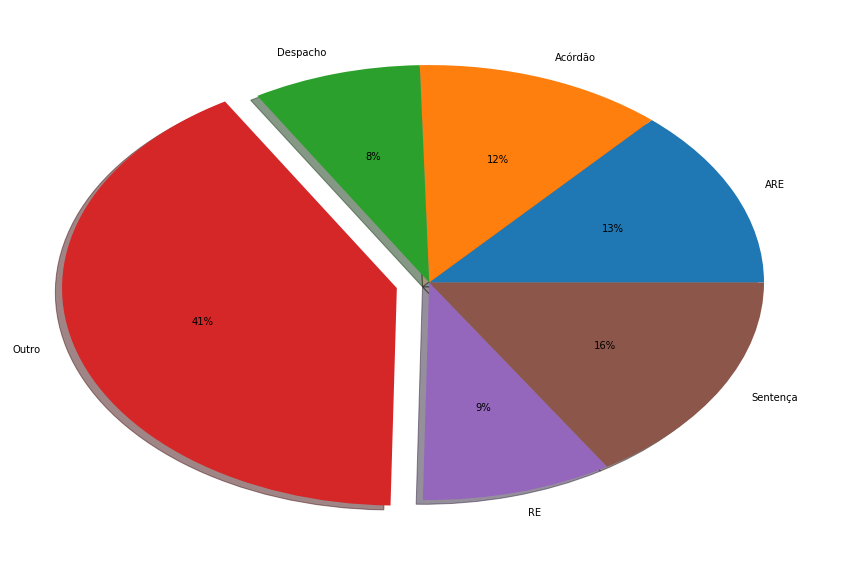

In [18]:
_ = plt.pie(labels, autopct='%1.0f%%',
        shadow=True,
        explode=[0.0, 0, 0.0, 0.1, 0.0, 0.0],
        labels=['ARE', 'Acórdão', 'Despacho', 'Outro', 'RE', 'Sentença']
       )

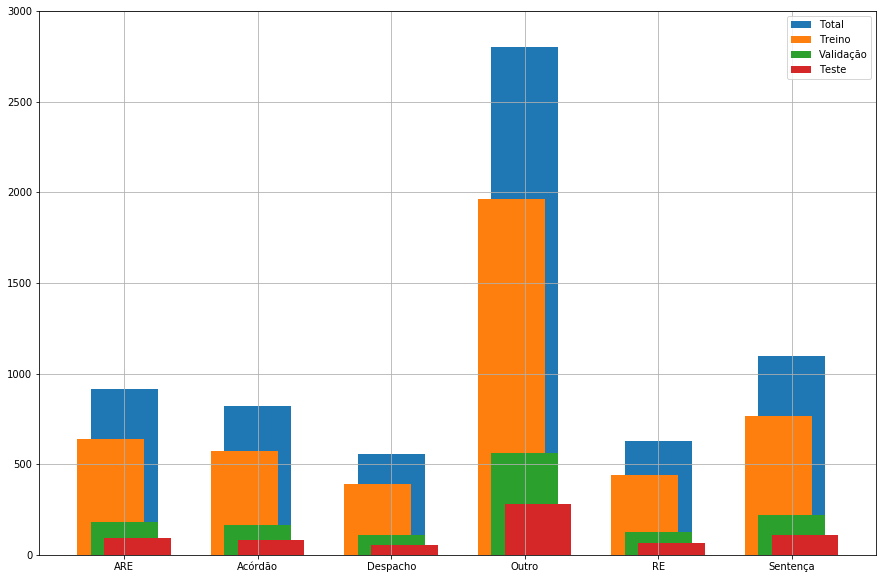

In [19]:
ind = np.arange(labels_index.size)
labels_legend = [ 'Total', 'Treino', 'Validação', 'Teste']
width = 0.5
plt.bar(ind + 0, labels, width=width)
plt.bar(ind - 0.1, label_train, width=width)
plt.bar(ind + 0.0, label_validation, width=width)
plt.bar(ind + 0.1, label_test, width=width)
plt.xticks(ind, ['ARE', 'Acórdão', 'Despacho', 'Outro', 'RE', 'Sentença'])
plt.ylim(ymax=3000)
plt.grid(True)
_ = plt.legend(labels_legend)

## Pre processing

Clone the [repository](https://gitlab.com/gpamstf/Pre-processing).

Install dependencies and pt_core_news_sm. Generate a pip package and install it.

```
git clone https://gitlab.com/gpamstf/Pre-processing.git
cd Pre-processing
pip3 install -r requirements.txt
python3 -m spacy download pt_core_news_sm
python3 setup.py sdist bdist_wheel
pip3 install dist/gpam_pre_processing-1.1-py3-none-any.whl
cd ..
rm -rf Pre-processing
```

In [20]:
from pre_processing.pre_processing import BatchProcessing

pipe = [ str.lower, 'clean_email', 'clean_site',
        'clean_document', 'transform_token', 'remove_letter_number',
        'clean_number', 'clean_alphachars', 'remove_small_big_words', 'clean_spaces',
        'remove_stop_words', 'snowball_stemmer'
       ]
train['pretext'] = BatchProcessing.parallel_processing(pipe, train.body, n_jobs=-1, progress=True)
validation['pretext'] = BatchProcessing.parallel_processing(pipe, validation.body, n_jobs=-1, progress=True)
test['pretext'] = BatchProcessing.parallel_processing(pipe, test.body, n_jobs=-1, progress=True)

100%|██████████| 682/682 [00:00<00:00, 1974.19it/s]


In [21]:
train['text'] = train.first_page
validation['text'] = validation.first_page
test['text'] = test.first_page

# Data transform

This section is to train models with a Unigram and Bag of Words and then transform the text with models.

|text|Tokenizer Unigram | BoW |
|----|------------------|-----|
|Exemplo de texto| [ [001], [010], [100] ] | [ 1 1 1] |
| Exemplo: texto | [ [001], [100] ] | [ 1 0 1 ] |
| texto text | [ [100], [100] ] | [ 2 0 0] |


### Tokenizer

This tokenizer is just a unigram technique.

In [24]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(train['text'])
len(tokenizer.word_counts)

42870

#### Save model

In [25]:
save_pickle(tokenizer, 'text-tokenizer')

### Tokenizer pre-processed 

In [26]:
pretokenizer = Tokenizer(num_words=MAX_FEATURES)
pretokenizer.fit_on_texts(train['pretext'])
len(pretokenizer.word_counts)

18670

#### Save model

In [27]:
save_pickle(pretokenizer, 'text-pretokenizer')

### Bag of words

In [28]:
count_vectorizer = CountVectorizer(
    max_features=MAX_FEATURES,
#     vocabulary=list(tokenizer.word_index.keys())
)
count_vectorizer.fit(train['text'])

# assert len(count_vectorizer.vocabulary_) == len(tokenizer.word_index), "The size of two text transformers aren't equal"
len(count_vectorizer.vocabulary_)

40542

#### Save model

In [29]:
save_pickle(count_vectorizer, 'text-count-vectorizer')

### Bag of words pre-processed

In [30]:
pcount_vectorizer = CountVectorizer(
    max_features=MAX_FEATURES,
#     vocabulary=list(tokenizer.word_index.keys())
)
pcount_vectorizer.fit(train['pretext'])

# assert len(count_vectorizer.vocabulary_) == len(tokenizer.word_index), "The size of two text transformers aren't equal"
len(pcount_vectorizer.vocabulary_)

18672

#### Save model

In [31]:
save_pickle(pcount_vectorizer, 'text-precount-vectorizer')

### Transform

#### Load tokenizer

In [32]:
tokenizer = load_pickle('text-tokenizer')

#### Transform

In [33]:
sequences_train = tokenizer.texts_to_sequences(train['text'])
sequences_validation = tokenizer.texts_to_sequences(validation['text'])
sequences_test = tokenizer.texts_to_sequences(test['text'])

# Equalizing the len of matriz
X_train = sequence.pad_sequences(sequences_train, maxlen=SEQUENCE_LEN, padding='post')
X_test = sequence.pad_sequences(sequences_test, maxlen=SEQUENCE_LEN, padding='post')
X_validation = sequence.pad_sequences(sequences_validation, maxlen=SEQUENCE_LEN, padding='post')

X_train.shape, X_validation.shape, X_test.shape

((4769, 1000), (1363, 1000), (682, 1000))

#### Signal form

This chart shows the distribution for word ID and its position in the text body.

mean: 262.88 +- 116.93
max:  945
min:  10
median:  239.0
tokens:  1253677


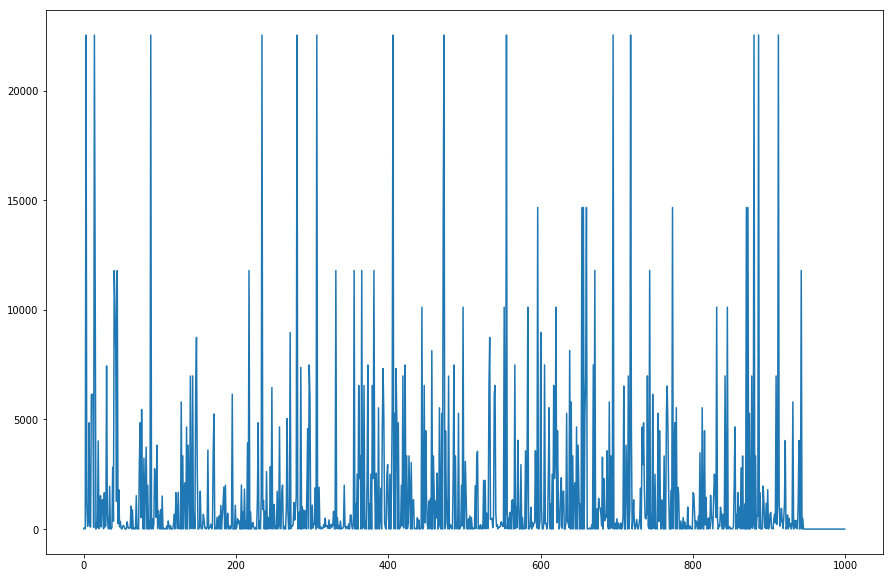

In [34]:
signal_sizes = np.count_nonzero(X_train, axis=1)
bigger_signal = signal_sizes.argmax()
plt.plot(X_train[bigger_signal])
print("mean: {:.2f} +- {:.2f}".format(np.mean(signal_sizes), np.std(signal_sizes)))
print("max: ", np.max(signal_sizes))
print("min: ", np.min(signal_sizes))
print("median: ", np.median(signal_sizes))
print("tokens: ", sum(tokenizer.word_counts.values()))

#### Load pretokenizer

In [35]:
pretokenizer = load_pickle('text-pretokenizer')

#### Transform

In [36]:
PSEQUENCE_LEN=1000
psequences_train = pretokenizer.texts_to_sequences(train['pretext'])
psequences_validation = pretokenizer.texts_to_sequences(validation['pretext'])
psequences_test = pretokenizer.texts_to_sequences(test['pretext'])

# Equalizing the len of matriz
PX_train = sequence.pad_sequences(psequences_train, maxlen=PSEQUENCE_LEN, padding='post')
PX_test = sequence.pad_sequences(psequences_test, maxlen=PSEQUENCE_LEN, padding='post')
PX_validation = sequence.pad_sequences(psequences_validation, maxlen=PSEQUENCE_LEN, padding='post')

PX_train.shape, PX_validation.shape, PX_test.shape

((4769, 1000), (1363, 1000), (682, 1000))

#### Signal form

This chart shows the distribution for word ID and its position in the text body.

mean: 145.83 +- 75.50
max:  790
min:  20
median:  128.0
tokens:  695485


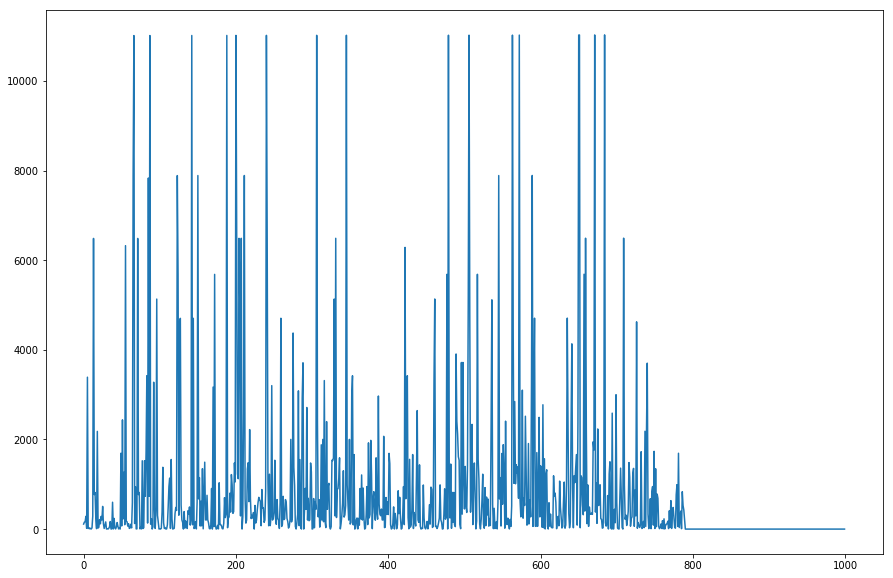

In [37]:
signal_sizes = np.count_nonzero(PX_train, axis=1)
bigger_signal = signal_sizes.argmax()
plt.plot(PX_train[bigger_signal])
print("mean: {:.2f} +- {:.2f}".format(np.mean(signal_sizes), np.std(signal_sizes)))
print("max: ", np.max(signal_sizes))
print("min: ", np.min(signal_sizes))
print("median: ", np.median(signal_sizes))
print("tokens: ", sum(pretokenizer.word_counts.values()))

#### Load count-vectorizer

In [38]:
count_vectorizer = load_pickle('text-count-vectorizer')

#### Transform

In [39]:
CX_train = count_vectorizer.transform(train.text)
CX_validation = count_vectorizer.transform(validation.text)
CX_test = count_vectorizer.transform(test.text)

CX_train.shape, CX_validation.shape, CX_test.shape

((4769, 40542), (1363, 40542), (682, 40542))

#### Load precount-vectorizer

In [40]:
pcount_vectorizer = load_pickle('text-precount-vectorizer')

#### Transform

In [41]:
PCX_train = pcount_vectorizer.transform(train['pretext'])
PCX_validation = pcount_vectorizer.transform(validation['pretext'])
PCX_test = pcount_vectorizer.transform(test['pretext'])

PCX_train.shape, PCX_validation.shape, PCX_test.shape

((4769, 18672), (1363, 18672), (682, 18672))

## Labels

The label of documents are parsed into numbers regarding the requirements of model implementation.

The Neural Networks implemented by Keras require a binarized label and the SVM from Scikit-Learn use the encoded label.

For example, see the table below.

|label|Binarizer|Encoder|
|-------|-----|------|
|Acórdão|[0 0 0 0 1 0] | 5 |
|RE|[1 0 0 0 0 0] | 1 |

### Binarizer

In [42]:
label_binarizer = LabelBinarizer()
label_binarizer.fit(train['label'])

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

#### Save model

In [43]:
save_pickle(label_binarizer, 'label-binarizer')

### Encoder

In [44]:
label_encoder = LabelEncoder()
label_encoder.fit(train['label'])

LabelEncoder()

#### Save model

In [45]:
save_pickle(label_encoder, 'label-encoder')

### Transform

#### Load binarizer

In [46]:
label_binarizer = load_pickle('label-binarizer')

#### Transform

In [47]:
Y_train = label_binarizer.transform(train['label'])
Y_test = label_binarizer.transform(test['label'])
Y_validation = label_binarizer.transform(validation['label'])
label_binarizer.classes_

array(['ARE', 'Acordão', 'Despacho', 'Outro', 'RE', 'Sentença'],
      dtype='<U8')

#### Load Encoder

In [48]:
label_encoder = load_pickle('label-encoder')

#### Transform

In [49]:
YY_train = label_encoder.transform(train['label'])
YY_validation = label_encoder.transform(validation['label'])
YY_test = label_encoder.transform(test['label'])
label_encoder.classes_

array(['ARE', 'Acordão', 'Despacho', 'Outro', 'RE', 'Sentença'],
      dtype=object)

# Base lines

## SVM

WANG, S.; MANNING, C. Baselines and Bigrams: Simple, Good Sentiment and Topic
Classification. 50th Annual Meeting of the Association for Computational Linguistics,
n. 50, p. 5, 2012.

### Train

In [50]:
kwargs_combination = [
    {'C': 1.0, 'kernel': 'linear', 'max_iter': 100000},
    {'C': 0.1, 'kernel': 'linear', 'max_iter': 100000},
    {'C': 0.1, 'kernel': 'linear', 'class_weight': 'balanced', 'max_iter': 100000},
    {'C': 1.0, 'kernel': 'poly', 'degree': 2},
    {'C': 0.1, 'kernel': 'poly', 'degree': 2},
    {'C': 0.1, 'kernel': 'poly', 'degree': 2, 'class_weight': 'balanced'},
    {'C': 0.1, 'kernel': 'rbf', 'class_weight': 'balanced', 'max_iter': 100000}
]

In [51]:
def grid_search(args, dataset):
    model = SVC(verbose=True, gamma='scale', **args)
    score = 0
    if dataset == 'bow':
        model.fit(CX_train, YY_train)
        score = model.score(CX_validation, YY_validation)
    elif dataset == 'prebow':
        model.fit(PCX_train, YY_train)
        score = model.score(PCX_validation, YY_validation)
    elif dataset == 'pretokenizer':
        model.fit(PX_train, YY_train)
        score = model.score(PX_validation, YY_validation)
    else:
        model.fit(X_train, YY_train)
        score = model.score(X_validation, YY_validation)
    return score, args, dataset

In [52]:
iters = []
for data in ['bow', 'prebow', 'tokenizer', 'pretokenizer']:
    iters.extend(
        [joblib.delayed(grid_search)(args, data) for args in kwargs_combination]
    )

scores = joblib.Parallel(n_jobs=-1)(
    tqdm(iters, total=len(iters)
))

 75%|███████▌  | 21/28 [01:58<00:39,  5.64s/it]/home/seth/pecas/.env/lib/python3.5/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 79%|███████▊  | 22/28 [02:25<00:39,  6.60s/it]/home/seth/pecas/.env/lib/python3.5/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 86%|████████▌ | 24/28 [02:33<00:25,  6.41s/it]/home/seth/pecas/.env/lib/python3.5/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
100%|██████████| 28/28 [03:40<00:00,  7.89s/it]
/home/seth/pecas/.env/lib/python3.5/site-packages/sklearn/svm/ba

In [53]:
scores

[(0.9060895084372708,
  {'C': 1.0, 'kernel': 'linear', 'max_iter': 100000},
  'bow'),
 (0.9119589141599413,
  {'C': 0.1, 'kernel': 'linear', 'max_iter': 100000},
  'bow'),
 (0.9126925898752751,
  {'C': 0.1,
   'class_weight': 'balanced',
   'kernel': 'linear',
   'max_iter': 100000},
  'bow'),
 (0.5458547322083639, {'C': 1.0, 'degree': 2, 'kernel': 'poly'}, 'bow'),
 (0.4115920763022744, {'C': 0.1, 'degree': 2, 'kernel': 'poly'}, 'bow'),
 (0.13352898019075568,
  {'C': 0.1, 'class_weight': 'balanced', 'degree': 2, 'kernel': 'poly'},
  'bow'),
 (0.6940572267057961,
  {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'rbf', 'max_iter': 100000},
  'bow'),
 (0.9053558327219369,
  {'C': 1.0, 'kernel': 'linear', 'max_iter': 100000},
  'prebow'),
 (0.9112252384446075,
  {'C': 0.1, 'kernel': 'linear', 'max_iter': 100000},
  'prebow'),
 (0.9178283198826119,
  {'C': 0.1,
   'class_weight': 'balanced',
   'kernel': 'linear',
   'max_iter': 100000},
  'prebow'),
 (0.5055025678650037, {'C': 1.0, 'degr

In [54]:
# {'C': 0.1, 'kernel': 'linear', 'class_weight': 'balanced', 'max_iter': 100000}

best_score, best_params, dataset = max(scores, key=lambda x: x[0])
best_score, best_params, dataset

(0.9178283198826119,
 {'C': 0.1,
  'class_weight': 'balanced',
  'kernel': 'linear',
  'max_iter': 100000},
 'prebow')

In [55]:
%%time
clf = SVC(verbose=True, **best_params)
clf.fit(CX_train, YY_train)

[LibSVM]CPU times: user 9.76 s, sys: 15.7 ms, total: 9.78 s
Wall time: 9.77 s


### Report

              precision    recall  f1-score   support

         ARE       0.97      0.97      0.97        92
     Acordão       0.87      0.87      0.87        82
    Despacho       0.90      0.84      0.87        55
       Outro       0.93      0.92      0.92       280
          RE       0.97      0.98      0.98        63
    Sentença       0.95      0.99      0.97       110

   micro avg       0.93      0.93      0.93       682
   macro avg       0.93      0.93      0.93       682
weighted avg       0.93      0.93      0.93       682

Accuracy:  0.9310850439882697


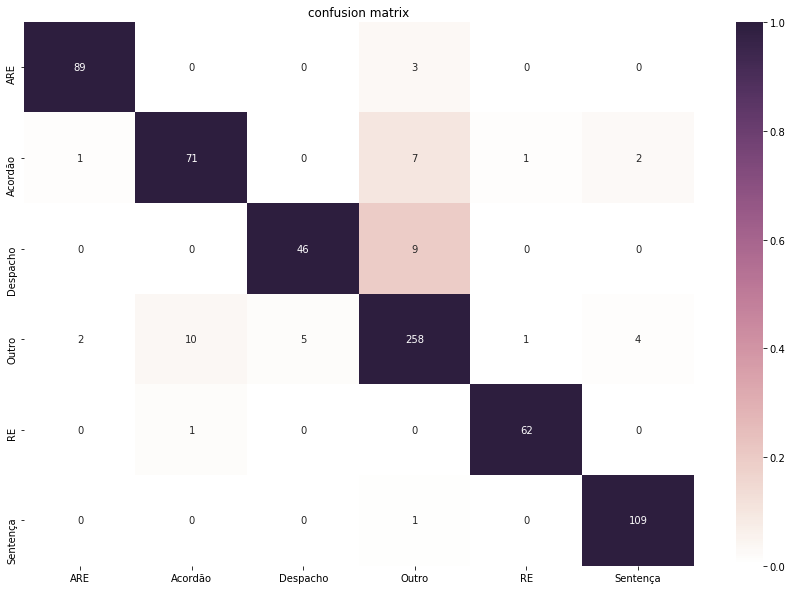

In [56]:
# %%time
# print(clf.score(XX_validation, YY_validation))

preds = clf.predict(CX_test)
report(YY_test, preds, label_encoder)

# NN

## Dense

In [57]:
# # Build model
model = Sequential()
model.add(Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN))
# model.add(Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=PSEQUENCE_LEN))
# model.add(Dropout(0.8))
model.add(Flatten())
model.add(Dense(200))
model.add(Dropout(0.8))
model.add(Dense(100))
model.add(Dropout(0.8))
model.add(Dense(NB_CLASS, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         7000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20000200  
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 606       
Total para

### Train

In [58]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_validation, Y_validation),
    epochs=EPOCHS,
    callbacks=get_checkpoint('model-emb-dense-dense.h5', ),
    batch_size=BATCH_SIZE,
)

Train on 4769 samples, validate on 1363 samples
Epoch 1/30
4769/4769 [==============================] - 2s 493us/step - loss: 8.8178 - acc: 0.3311 - val_loss: 7.7405 - val_acc: 0.4351

Epoch 00001: val_acc improved from -inf to 0.43507, saving model to /home/seth/marcelo/tcc/models/model-emb-dense-dense.h5
Epoch 2/30
4769/4769 [==============================] - 0s 90us/step - loss: 5.0011 - acc: 0.3546 - val_loss: 1.0627 - val_acc: 0.5987

Epoch 00002: val_acc improved from 0.43507 to 0.59868, saving model to /home/seth/marcelo/tcc/models/model-emb-dense-dense.h5
Epoch 3/30
4769/4769 [==============================] - 0s 91us/step - loss: 1.3801 - acc: 0.5299 - val_loss: 0.7924 - val_acc: 0.7660

Epoch 00003: val_acc improved from 0.59868 to 0.76596, saving model to /home/seth/marcelo/tcc/models/model-emb-dense-dense.h5
Epoch 4/30
4769/4769 [==============================] - 0s 93us/step - loss: 0.9447 - acc: 0.6844 - val_loss: 0.6589 - val_acc: 0.8122

Epoch 00004: val_acc improved fr

### Report

682/682 [==============================] - 0s 117us/step
              precision    recall  f1-score   support

         ARE       0.94      0.99      0.96        92
     Acordão       0.85      0.84      0.85        82
    Despacho       0.89      0.85      0.87        55
       Outro       0.95      0.88      0.91       280
          RE       0.97      1.00      0.98        63
    Sentença       0.87      0.99      0.92       110

   micro avg       0.92      0.92      0.92       682
   macro avg       0.91      0.93      0.92       682
weighted avg       0.92      0.92      0.92       682

Accuracy:  0.9164222873900293


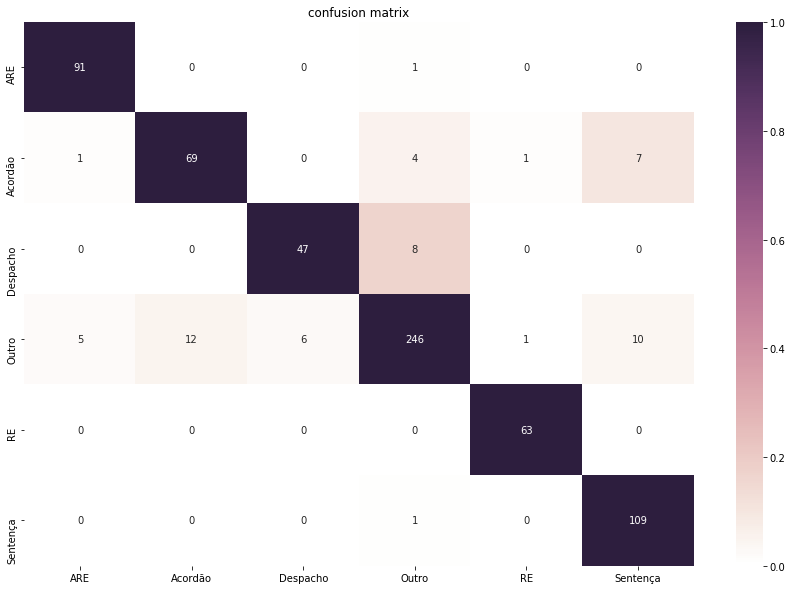

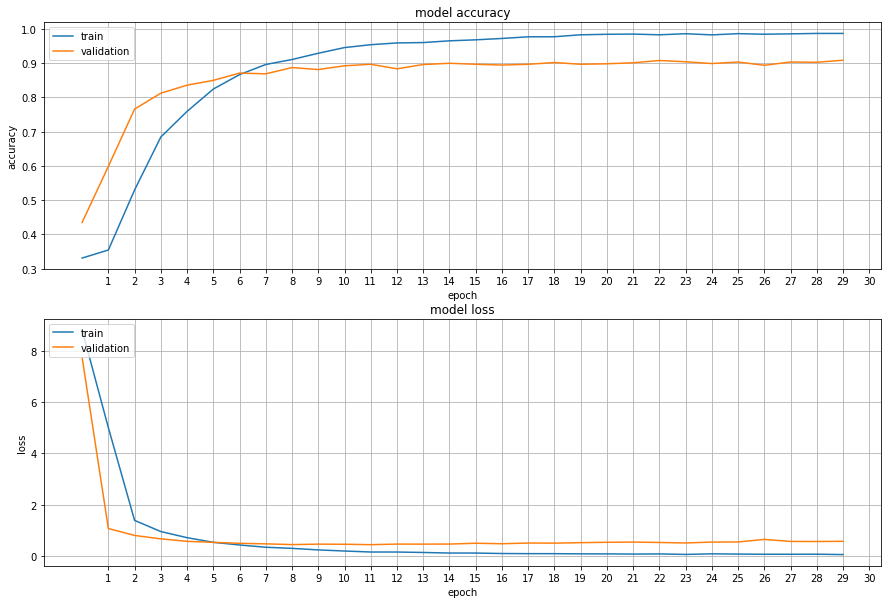

29 [0.3310966658052295, 0.35458167348174985, 0.5298804777002004, 0.6844202136938415, 0.7590689869465931, 0.8242818192631775, 0.8664290209090493, 0.895994966811018, 0.9104634104321953, 0.9287062277956862, 0.9452715448474304, 0.9536590485058882, 0.9589012375065905, 0.9599496759591449, 0.964982176906884, 0.9679178017119138, 0.9719018660818514, 0.9767246807138983, 0.976934367654508, 0.9825959326861464, 0.9840637450199203, 0.9846928082039381, 0.9825959312988293, 0.9857412447817397, 0.98238624359582, 0.9859509331096666, 0.9842734318230482, 0.9853218710380022, 0.9865799956687669, 0.9865799949063673] [0.43506969913829363, 0.5986793821818323, 0.7659574460650924, 0.8121790183176473, 0.835656638059735, 0.8495964797996722, 0.8708730723957585, 0.8686720483983517, 0.8870139381331026, 0.881144532410432, 0.8921496681404394, 0.8965517224324423, 0.8833455605185041, 0.895818049865703, 0.8994864284423721, 0.8965517255810369, 0.8943506984350355, 0.8965517246189664, 0.9016874555883736, 0.8965517255810369, 0

In [59]:
model = load_model('model-emb-dense-dense')
pred = model.predict(X_test, verbose=1)
report(Y_test, pred, label_binarizer, history)

### Save model

In [60]:
# save_model(model, 'model-emb-dense.h5')

# RNN Architectures

## LSTM

HOCHREITER, S.; SCHMIDHUBER, J. Long short-term memory. Neural Computation,
v. 9, n. 8, p. 1735–1780, nov. 1997. ISSN 0899-7667.

In [61]:
model = Sequential()
# model.add(Embedding(input_dim=EMBEDDING_DIM, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN))
model.add(Embedding(input_dim=EMBEDDING_DIM, output_dim=EMBEDDING_OUT, input_length=PSEQUENCE_LEN))
model.add(CuDNNLSTM(units=UNITS, return_sequences=True))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(NB_CLASS, activation='softmax'))

model.compile('adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         7000000   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 1000, 100)         80800     
_________________________________________________________________
flatten_2 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6400064   
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 390       
Total params: 13,481,254
Trainable params: 13,481,254
Non-trainable params: 0
________________________________________________________________

### Train

In [62]:
history = model.fit(
    PX_train, Y_train,
    validation_data=(PX_validation, Y_validation),
    epochs=EPOCHS,
    callbacks=get_checkpoint('model-lstm.h5',),
    batch_size=BATCH_SIZE,
)

Train on 4769 samples, validate on 1363 samples
Epoch 1/30
4769/4769 [==============================] - 6s 1ms/step - loss: 1.6831 - acc: 0.3605 - val_loss: 1.3252 - val_acc: 0.5231

Epoch 00001: val_acc improved from -inf to 0.52311, saving model to /home/seth/marcelo/tcc/models/model-lstm.h5
Epoch 2/30
4769/4769 [==============================] - 1s 310us/step - loss: 1.2032 - acc: 0.5077 - val_loss: 0.7988 - val_acc: 0.6537

Epoch 00002: val_acc improved from 0.52311 to 0.65371, saving model to /home/seth/marcelo/tcc/models/model-lstm.h5
Epoch 3/30
4769/4769 [==============================] - 2s 315us/step - loss: 0.8103 - acc: 0.6637 - val_loss: 0.5141 - val_acc: 0.8709

Epoch 00003: val_acc improved from 0.65371 to 0.87087, saving model to /home/seth/marcelo/tcc/models/model-lstm.h5
Epoch 4/30
4769/4769 [==============================] - 1s 311us/step - loss: 0.5213 - acc: 0.8081 - val_loss: 0.3428 - val_acc: 0.9061

Epoch 00004: val_acc improved from 0.87087 to 0.90609, saving mo

### Report

682/682 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

         ARE       0.96      1.00      0.98        92
     Acordão       0.82      0.95      0.88        82
    Despacho       0.91      0.89      0.90        55
       Outro       0.97      0.91      0.94       280
          RE       0.98      0.98      0.98        63
    Sentença       0.96      0.96      0.96       110

   micro avg       0.94      0.94      0.94       682
   macro avg       0.93      0.95      0.94       682
weighted avg       0.94      0.94      0.94       682

Accuracy:  0.9413489736070382


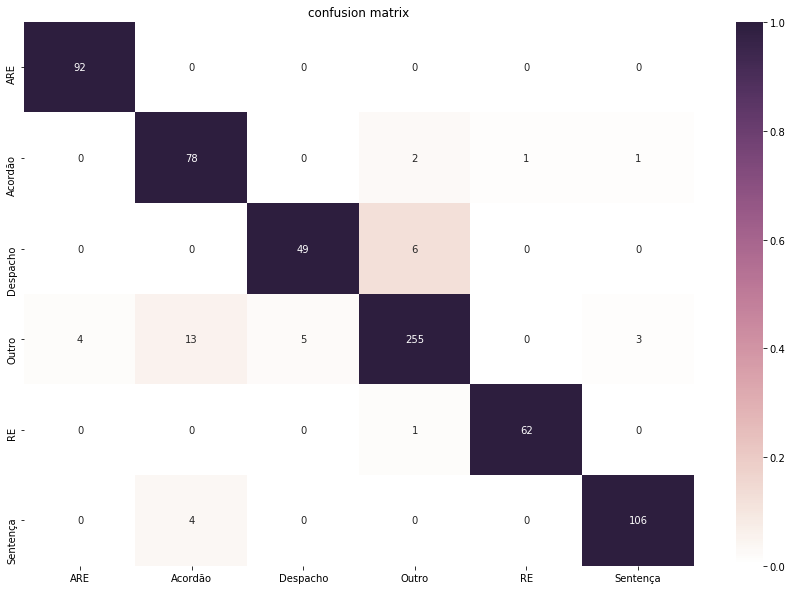

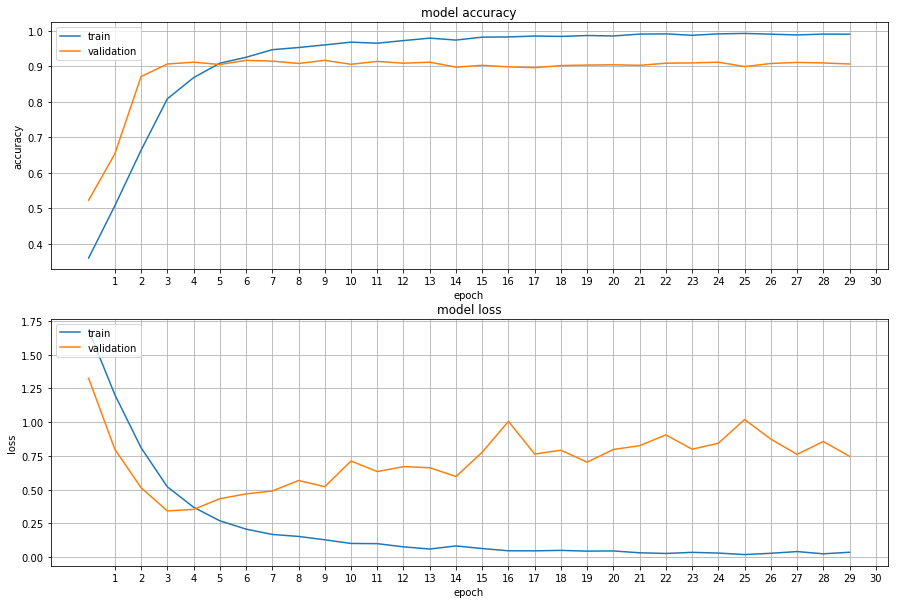

9 [0.3604529246603525, 0.5076535953418542, 0.6636611447066325, 0.8081358769300424, 0.8676871459522595, 0.9083665334520962, 0.9249318512662399, 0.946319982950031, 0.9524009223503246, 0.9597399872812642, 0.9674984264433771, 0.9645628017758293, 0.9719018660818514, 0.978821556369172, 0.9733696782781434, 0.9815474940961101, 0.9821765574176098, 0.9846928082039381, 0.9836443705137833, 0.986160620537712, 0.9849024959069475, 0.9901446850451315, 0.990773747116796, 0.9867896838592118, 0.9907737477417136, 0.9920318717475607, 0.9899349974796041, 0.9878381211994128, 0.9901446844202139, 0.9899349967172046] [0.5231107849018239, 0.653705062100053, 0.8708730745822826, 0.906089506731782, 0.9112252384446075, 0.9046221579686736, 0.9163609684519443, 0.914159939600454, 0.907556860830009, 0.9163609689329796, 0.9053558332029722, 0.9134262665526796, 0.9082905360643074, 0.9112252389256428, 0.8972854003343002, 0.9024211303416368, 0.89801907386311, 0.8958180489036325, 0.9016874546263031, 0.903154806538006, 0.90388

In [63]:
model = load_model('model-lstm')
pred = model.predict(PX_test, verbose=1)
report(Y_test, pred, label_binarizer, history)

## Bi-LSTM

BRAZ, F. A. et al. Document classification using a Bi-LSTM to unclog Brazil’s supreme
court. In: 32st Conference on Neural Information Processing Systems (NIPS). Montreal,
CA: [s.n.], 2018.

In [64]:
model = Sequential()
model.add(Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN))
# model.add(Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=PSEQUENCE_LEN))
# merges modes can be: sum, ave, concat, mul
model.add(Bidirectional(CuDNNLSTM(units=UNITS, return_sequences=True), merge_mode='ave'))  # Use CuDNNLSTM to use in GPU
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(NB_CLASS, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 100)         7000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 100)         161600    
_________________________________________________________________
flatten_3 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                3200032   
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 198       
Total params: 10,361,830
Trainable params: 10,361,830
Non-trainable params: 0
________________________________________________________________

### Train

In [65]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_validation, Y_validation),
    epochs=EPOCHS,
    callbacks=get_checkpoint('model-embe-bilstm-dense.h5', ),
    batch_size=BATCH_SIZE,
)

Train on 4769 samples, validate on 1363 samples
Epoch 1/30
4769/4769 [==============================] - 5s 952us/step - loss: 1.5819 - acc: 0.3898 - val_loss: 1.2456 - val_acc: 0.5099

Epoch 00001: val_acc improved from -inf to 0.50990, saving model to /home/seth/marcelo/tcc/models/model-embe-bilstm-dense.h5
Epoch 2/30
4769/4769 [==============================] - 3s 577us/step - loss: 1.0666 - acc: 0.5611 - val_loss: 0.7256 - val_acc: 0.7535

Epoch 00002: val_acc improved from 0.50990 to 0.75348, saving model to /home/seth/marcelo/tcc/models/model-embe-bilstm-dense.h5
Epoch 3/30
4769/4769 [==============================] - 3s 579us/step - loss: 0.6855 - acc: 0.7268 - val_loss: 0.5008 - val_acc: 0.8202

Epoch 00003: val_acc improved from 0.75348 to 0.82025, saving model to /home/seth/marcelo/tcc/models/model-embe-bilstm-dense.h5
Epoch 4/30
4769/4769 [==============================] - 3s 580us/step - loss: 0.4747 - acc: 0.8018 - val_loss: 0.3966 - val_acc: 0.9046

Epoch 00004: val_acc im

### Report

682/682 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

         ARE       0.95      0.99      0.97        92
     Acordão       0.87      0.87      0.87        82
    Despacho       0.90      0.84      0.87        55
       Outro       0.93      0.93      0.93       280
          RE       0.98      0.98      0.98        63
    Sentença       0.96      0.97      0.96       110

   micro avg       0.93      0.93      0.93       682
   macro avg       0.93      0.93      0.93       682
weighted avg       0.93      0.93      0.93       682

Accuracy:  0.9325513196480938


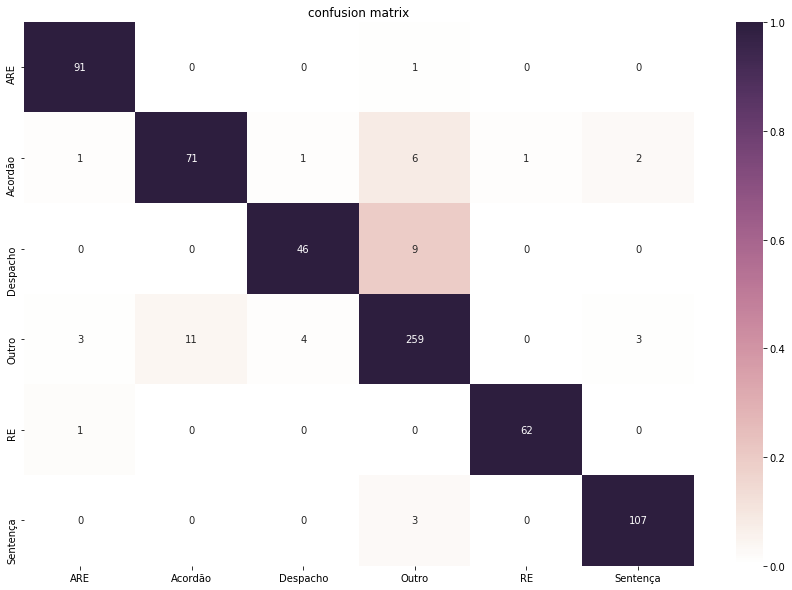

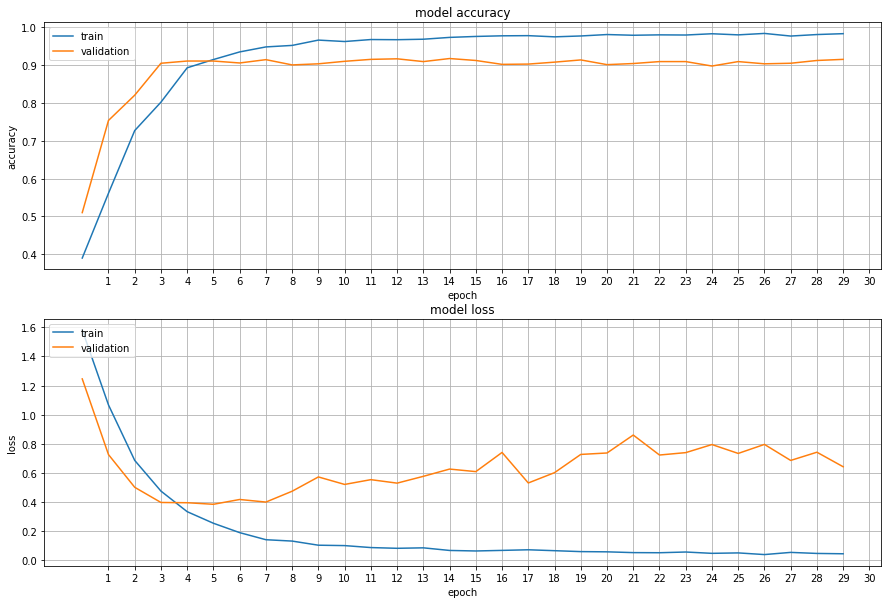

14 [0.38980918424662914, 0.5611239261386229, 0.7267771015804152, 0.8018452496892577, 0.8926399670124154, 0.9144474734773074, 0.9345774790055348, 0.9477877966711221, 0.9517718609035778, 0.9658209271689935, 0.9620465503645833, 0.9672887395027674, 0.9668693648591484, 0.9681274899023588, 0.9729503043969239, 0.9754665546958166, 0.9771440549450716, 0.9775634309760078, 0.9744181168681797, 0.9767246799514988, 0.9804990562684732, 0.9786118689411265, 0.9796603053814461, 0.9792409315002267, 0.9825959319237468, 0.9796603053814461, 0.9834346821858564, 0.976514993148371, 0.9804990570308728, 0.9828056188643566] [0.5099046232939991, 0.7534849598664881, 0.8202494502242488, 0.9046221574876384, 0.9104915615048202, 0.9104915615048202, 0.9053558341650427, 0.914159939600454, 0.9002201010091114, 0.903154804351482, 0.9097578874949751, 0.9148936184643824, 0.9163609667464555, 0.9090242095931172, 0.9170946429428246, 0.9119589124544526, 0.9016874529208143, 0.9024211286361482, 0.9075568581624497, 0.913426266552679

In [66]:
model = load_model('model-embe-bilstm-dense')
pred = model.predict(X_test, verbose=1)
report(Y_test, pred, label_binarizer, history)

### Save model

Save the model in path of models

In [67]:
# save_model(model, 'model-embe-bilstm-dense.h5')

## Bi-RNN

SCHUSTER, M.; PALIWAL, K. K. Bidirectional recurrent neural networks. IEEE
Transactions on Signal Processing, v. 45, n. 11, p. 2673–2681, nov. 1997. ISSN 1053-587X.

In [68]:
model = Sequential()
# model.add(Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN))
model.add(Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=PSEQUENCE_LEN))
# merges modes can be: sum, ave, concat, mul
model.add(Bidirectional(SimpleRNN(units=UNITS, return_sequences=True, dropout=0.2, ), merge_mode='sum'))  # Use CuDNNLSTM to use in GPU
model.add(Flatten())
# model.add(Dense(32, activation='relu'))
model.add(Dense(NB_CLASS, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 1000, 100)         7000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1000, 100)         40200     
_________________________________________________________________
flatten_4 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 600006    
Total params: 7,640,206
Trainable params: 7,640,206
Non-trainable params: 0
_________________________________________________________________


### Train

In [69]:
history = model.fit(
    PX_train, Y_train,
    validation_data=(PX_validation, Y_validation),
    epochs=EPOCHS,
    callbacks=get_checkpoint('model-embe-birnn-dense.h5'),
    batch_size=BATCH_SIZE
)

Train on 4769 samples, validate on 1363 samples
Epoch 1/30
4769/4769 [==============================] - 14s 3ms/step - loss: 3.3539 - acc: 0.3510 - val_loss: 1.4324 - val_acc: 0.4798

Epoch 00001: val_acc improved from -inf to 0.47982, saving model to /home/seth/marcelo/tcc/models/model-embe-birnn-dense.h5
Epoch 2/30
4769/4769 [==============================] - 11s 2ms/step - loss: 3.7614 - acc: 0.3867 - val_loss: 1.8734 - val_acc: 0.5158

Epoch 00002: val_acc improved from 0.47982 to 0.51577, saving model to /home/seth/marcelo/tcc/models/model-embe-birnn-dense.h5
Epoch 3/30
4769/4769 [==============================] - 11s 2ms/step - loss: 4.4127 - acc: 0.3988 - val_loss: 3.3563 - val_acc: 0.4182

Epoch 00003: val_acc did not improve from 0.51577
Epoch 4/30
4769/4769 [==============================] - 11s 2ms/step - loss: 4.6006 - acc: 0.4192 - val_loss: 1.0727 - val_acc: 0.6544

Epoch 00004: val_acc improved from 0.51577 to 0.65444, saving model to /home/seth/marcelo/tcc/models/model-

### Report

682/682 [==============================] - 7s 10ms/step
              precision    recall  f1-score   support

         ARE       0.88      0.89      0.89        92
     Acordão       0.69      0.80      0.75        82
    Despacho       0.81      0.76      0.79        55
       Outro       0.92      0.87      0.90       280
          RE       0.86      0.90      0.88        63
    Sentença       0.88      0.91      0.90       110

   micro avg       0.87      0.87      0.87       682
   macro avg       0.84      0.86      0.85       682
weighted avg       0.87      0.87      0.87       682

Accuracy:  0.8651026392961877


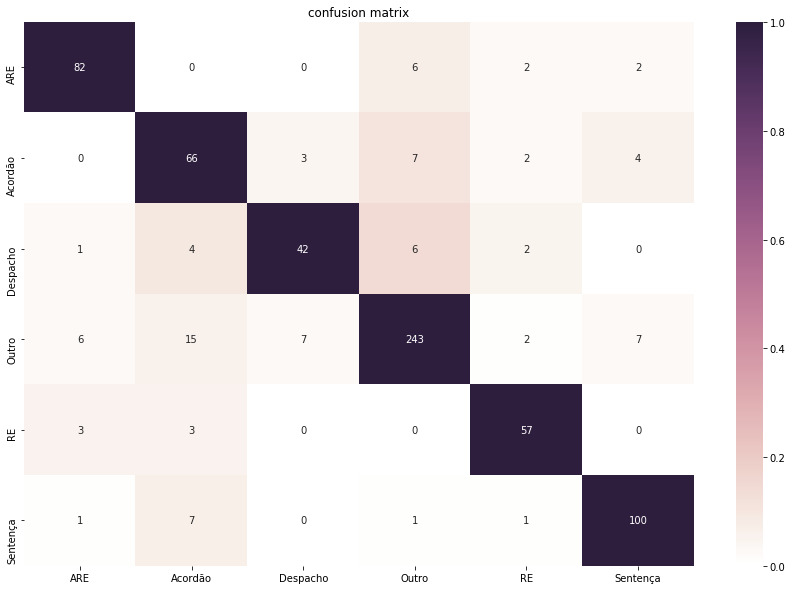

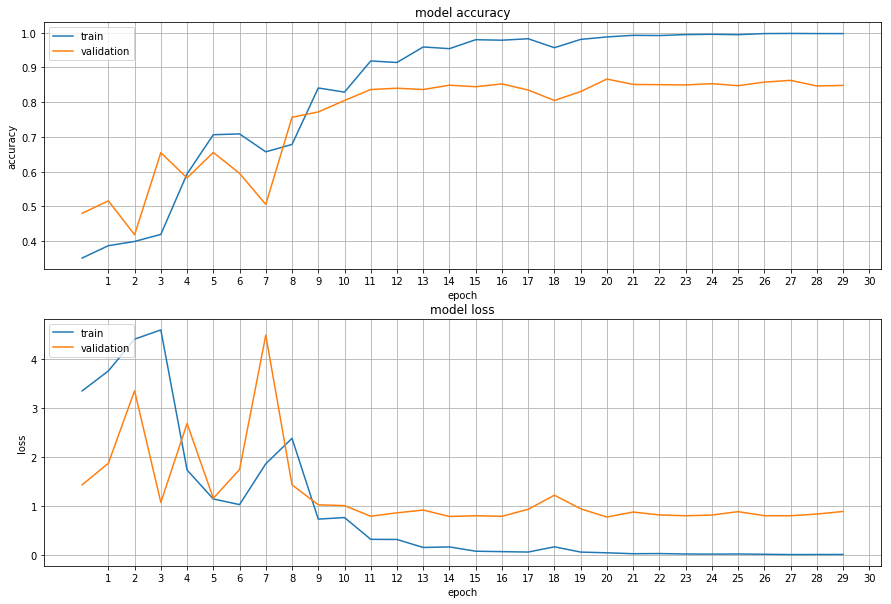

20 [0.351016984774047, 0.38666387079496456, 0.39882574960492545, 0.41916544386415167, 0.5934158108611356, 0.7062277209961232, 0.7085342844293961, 0.6569511426222552, 0.6781295867905124, 0.840847137427275, 0.8288949457047795, 0.9186412246503728, 0.9142377854243443, 0.9589012362567552, 0.9540784230120254, 0.9798699941968088, 0.9784021813755991, 0.982595931786265, 0.9568043606014816, 0.9807087436965187, 0.9878381218243305, 0.9924512482659326, 0.9918221849444327, 0.994548122533889, 0.9953868741833156, 0.9943384363556788, 0.9974837492136717, 0.9979031243447264, 0.9974837492136717, 0.9974837492136717] [0.4798239187029295, 0.5157740278796772, 0.4181951577402788, 0.6544387365472029, 0.5818048418661469, 0.6551724133995291, 0.5950110043704466, 0.5055025690457267, 0.7564196610223346, 0.7718268527498336, 0.8048422587154022, 0.8363903139937212, 0.8400586944945315, 0.8363903139937212, 0.8488628043029909, 0.8444607487865344, 0.8525311821362418, 0.8349229647495776, 0.8048422604208909, 0.83052091045757

In [70]:
model = load_model('model-embe-birnn-dense')
pred = model.predict(PX_test, verbose=1)
report(Y_test, pred, label_binarizer, history)

### Save model

Save the model in path of models

In [71]:
# save_model(model, 'model-embe-bilstm-dense.h5')

# Convolution architectures

## Convolutional

SILVA, N. C. da et al. Document type classification for Brazil’s supreme court using
a Convolutional Neural Network. In: 10th International Conference on Forensic
Computer Science and Cyber Law. São Paulo, SP: [s.n.], 2018. p. 4. Disponível em:
<http://icofcs.org/2018/papers-accepted.html>.

In [72]:
model = Sequential()
model.add(Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN))

model.add(Conv1D(kernel_size=4, filters=256, padding='same', ))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(64, activation='relu', ))
model.add(Dropout(0.7))
model.add(Dense(NB_CLASS, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 100)         7000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 256)         102656    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 256)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 128000)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8192064   
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 390       
Total para

### Train

In [73]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_validation, Y_validation),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=get_checkpoint('model-emb-cnn.h5', )
)

Train on 4769 samples, validate on 1363 samples
Epoch 1/30
4769/4769 [==============================] - 5s 992us/step - loss: 1.8565 - acc: 0.2952 - val_loss: 1.6040 - val_acc: 0.4226

Epoch 00001: val_acc improved from -inf to 0.42260, saving model to /home/seth/marcelo/tcc/models/model-emb-cnn.h5
Epoch 2/30
4769/4769 [==============================] - 1s 214us/step - loss: 1.5692 - acc: 0.3617 - val_loss: 1.2957 - val_acc: 0.4585

Epoch 00002: val_acc improved from 0.42260 to 0.45855, saving model to /home/seth/marcelo/tcc/models/model-emb-cnn.h5
Epoch 3/30
4769/4769 [==============================] - 1s 214us/step - loss: 1.2800 - acc: 0.4567 - val_loss: 0.9897 - val_acc: 0.5495

Epoch 00003: val_acc improved from 0.45855 to 0.54952, saving model to /home/seth/marcelo/tcc/models/model-emb-cnn.h5
Epoch 4/30
4769/4769 [==============================] - 1s 216us/step - loss: 0.9839 - acc: 0.5785 - val_loss: 0.6374 - val_acc: 0.7667

Epoch 00004: val_acc improved from 0.54952 to 0.76669

### Report

682/682 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

         ARE       0.95      0.99      0.97        92
     Acordão       0.85      0.84      0.85        82
    Despacho       0.91      0.87      0.89        55
       Outro       0.94      0.92      0.93       280
          RE       0.97      0.97      0.97        63
    Sentença       0.94      1.00      0.97       110

   micro avg       0.93      0.93      0.93       682
   macro avg       0.93      0.93      0.93       682
weighted avg       0.93      0.93      0.93       682

Accuracy:  0.9325513196480938


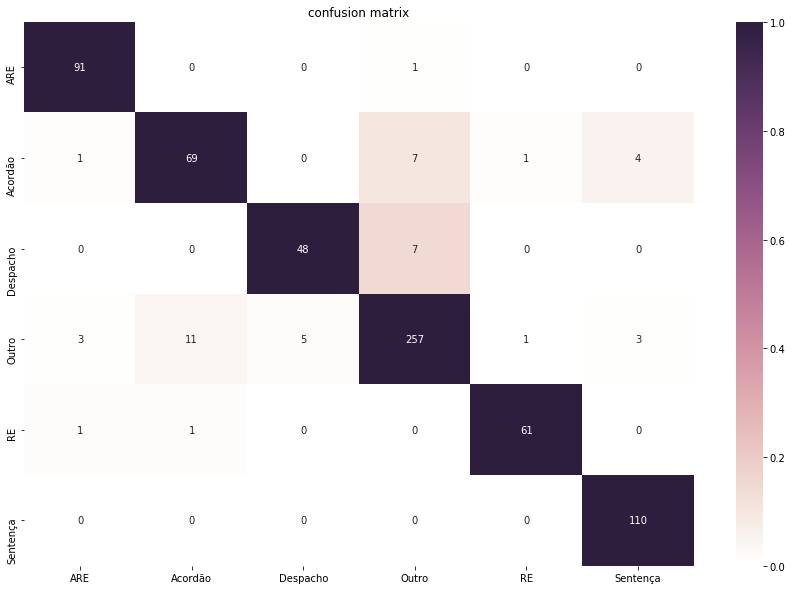

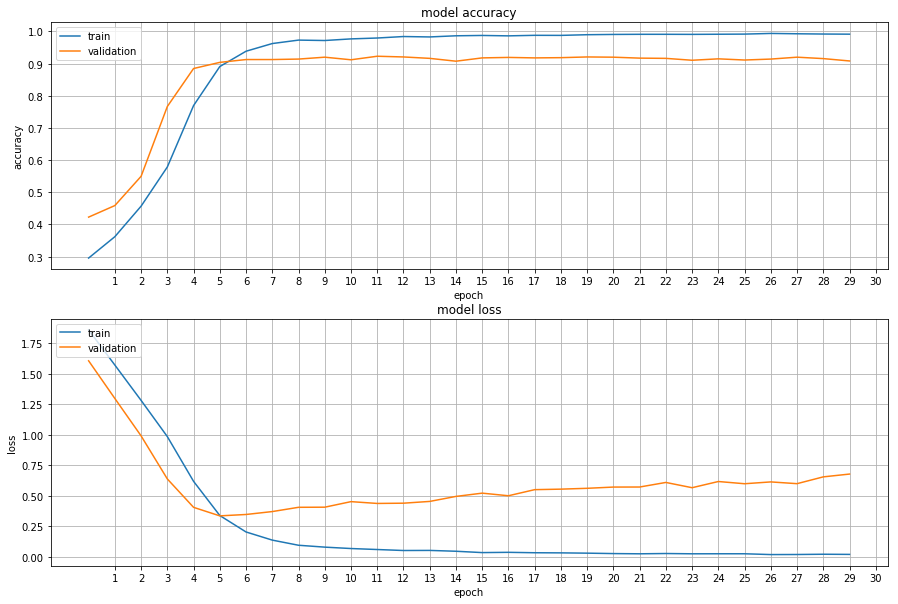

11 [0.29524009196256834, 0.36171105102838824, 0.45669951775609435, 0.5785279934524765, 0.7695533662603246, 0.8909624653758431, 0.938561544137872, 0.9624659262580376, 0.9731599913375336, 0.9719018659443694, 0.976934367654508, 0.9796603064937995, 0.9842734324479658, 0.9830153078172011, 0.9865799950438492, 0.9876284334964036, 0.9863703074783218, 0.988047809252376, 0.9878381218243305, 0.9899349965797227, 0.9907737477417136, 0.9911931214854511, 0.9911931222478507, 0.9909834345448415, 0.991402809813378, 0.9918221855693504, 0.993919061224624, 0.9928706227720696, 0.9920318731348778, 0.9916124966165059] [0.42259721264450845, 0.4585473221711, 0.5495231113972597, 0.7666911215180434, 0.8848129109871011, 0.9038884795857806, 0.912692591318381, 0.912692591318381, 0.9141599427490487, 0.9200293453231246, 0.9119589156030472, 0.9229640513330545, 0.920763024187053, 0.9163609698950501, 0.9075568613110442, 0.9178283213257178, 0.9192956727563854, 0.9178283213257178, 0.9185619970410516, 0.920763024187053, 0.9

In [74]:
model = load_model('model-emb-cnn')
pred = model.predict(X_test, verbose=1)
report(Y_test, pred, label_binarizer, history)

### Save model

In [75]:
# save_model(model, 'model-emb-conv-dense.h5')

## Very deep

CONNEAU, A. et al. Very Deep Convolutional Networks for Text Classification. In:
Proceedings of the 15th Conference of the European Chapter of the Association for
Computational Linguistics: Volume 1, Long Papers. Valencia, Spain: Association for
Computational Linguistics, 2017. p. 1107–1116. Disponível em: <http://aclweb.org/
anthology/E17-1104>.

In [76]:
model = Sequential([
    Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN),
    Conv1D(64, 3, padding="same")
])

# 4 pairs of convolution blocks followed by pooling
for filter_size in [64, 128, 256,]:

    # each iteration is a convolution block
    for cb_i in [0,1]:
        model.add(Conv1D(filters=filter_size, kernel_size=3, padding="same"))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(Conv1D(filters=filter_size, kernel_size=3, padding="same")),
        model.add(BatchNormalization())
        model.add(Activation("relu"))

    model.add(MaxPooling1D(pool_size=2, strides=3))

# model.add(KMaxPooling(k=2))
model.add(Flatten())
model.add(Dense(296, activation="relu"))
model.add(Dense(148, activation="relu"))
model.add(Dense(148, activation="relu"))
model.add(Dropout(0.8))
model.add(Dense(NB_CLASS, activation="softmax"))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 1000, 100)         7000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1000, 64)          19264     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1000, 64)          12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 64)          256       
_________________________________________________________________
activation_1 (Activation)    (None, 1000, 64)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1000, 64)          12352     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000, 64)          256       
__________

### Train

In [77]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_validation, Y_validation),
    epochs=EPOCHS,
    callbacks=get_checkpoint('model-very-deep-cnn.h5', ),
    batch_size=BATCH_SIZE,
)

Train on 4769 samples, validate on 1363 samples
Epoch 1/30
4769/4769 [==============================] - 12s 2ms/step - loss: 2.0551 - acc: 0.2866 - val_loss: 1.6943 - val_acc: 0.4035

Epoch 00001: val_acc improved from -inf to 0.40352, saving model to /home/seth/marcelo/tcc/models/model-very-deep-cnn.h5
Epoch 2/30
4769/4769 [==============================] - 3s 552us/step - loss: 1.4732 - acc: 0.4137 - val_loss: 1.3987 - val_acc: 0.4960

Epoch 00002: val_acc improved from 0.40352 to 0.49596, saving model to /home/seth/marcelo/tcc/models/model-very-deep-cnn.h5
Epoch 3/30
4769/4769 [==============================] - 3s 553us/step - loss: 1.1898 - acc: 0.5202 - val_loss: 1.4113 - val_acc: 0.5275

Epoch 00003: val_acc improved from 0.49596 to 0.52751, saving model to /home/seth/marcelo/tcc/models/model-very-deep-cnn.h5
Epoch 4/30
4769/4769 [==============================] - 3s 552us/step - loss: 0.8998 - acc: 0.6542 - val_loss: 1.8617 - val_acc: 0.5312

Epoch 00004: val_acc improved from 0

### Report

682/682 [==============================] - 4s 6ms/step
              precision    recall  f1-score   support

         ARE       0.88      0.88      0.88        92
     Acordão       0.90      0.55      0.68        82
    Despacho       0.55      0.87      0.67        55
       Outro       0.86      0.87      0.86       280
          RE       0.82      0.87      0.85        63
    Sentença       0.88      0.83      0.85       110

   micro avg       0.83      0.83      0.83       682
   macro avg       0.82      0.81      0.80       682
weighted avg       0.84      0.83      0.83       682

Accuracy:  0.8255131964809385


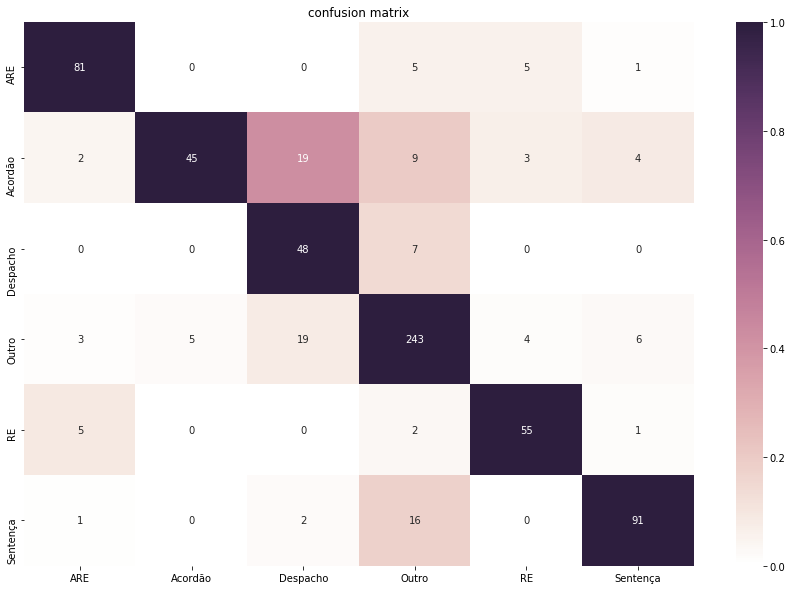

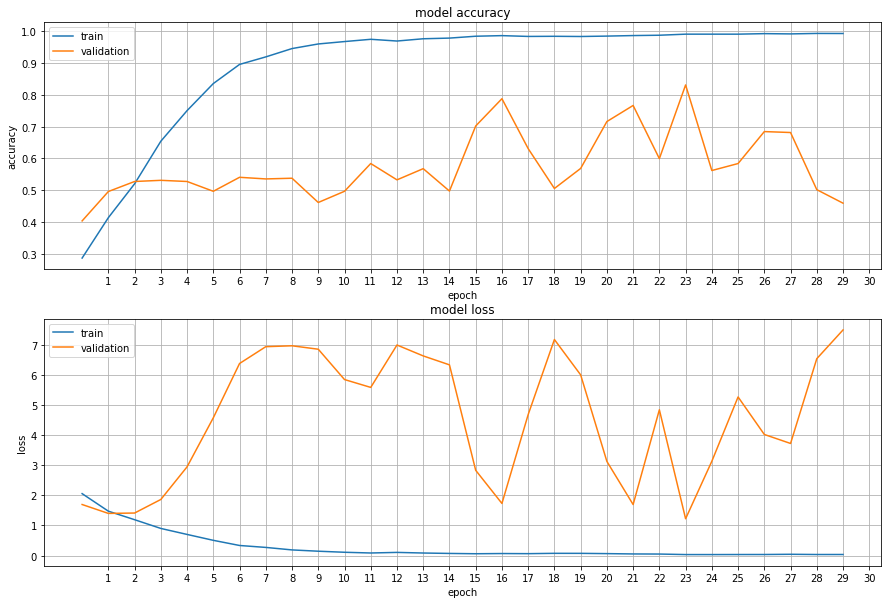

23 [0.2866429018071923, 0.41371356630430306, 0.5202348500358955, 0.6542252041204192, 0.7504717974598789, 0.8356049495389262, 0.8957852807702896, 0.9194799741500828, 0.945690920115967, 0.9601593616499194, 0.9677081146338221, 0.9748374912368349, 0.9693856145331234, 0.9765149925234533, 0.9786118688036446, 0.9844831207758927, 0.9863703088656389, 0.9838540566919934, 0.9842734324479658, 0.9836443697513837, 0.9849024957694655, 0.9865799950438492, 0.9876284328714859, 0.9909834339199238, 0.990983435307241, 0.9909834346823233, 0.9926609358314599, 0.9918221854318685, 0.993289998528042, 0.9930803102001151] [0.4035216428651061, 0.4959647839592383, 0.5275128402433584, 0.5311812182952618, 0.5275128391938269, 0.4966984586250406, 0.5407190038190549, 0.5355832732869524, 0.5377843009577197, 0.4614820249176428, 0.4966984593793914, 0.5840058681812692, 0.5326485701632342, 0.5678650028812299, 0.49743213508652573, 0.7021276600117728, 0.7879677165630365, 0.6309611141812863, 0.5055025678376721, 0.56859867929625

In [78]:
model = load_model('model-very-deep-cnn')
pred = model.predict(X_test, verbose=1)
report(Y_test, pred, label_binarizer, history)

### Save model

In [79]:
# save_model(model, 'model-very-deep-cnn.h5')

## Sentense classification

KIM, Y. Convolutional Neural Networks for Sentence Classification. In: Proceedings of
the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP).
Doha, Qatar: Association for Computational Linguistics, 2014. p. 1746–1751. Disponível
em: <http://aclweb.org/anthology/D14-1181>.

In [90]:
# SEQUENCE_LEN = 2000
text_seq_input = Input(shape=(SEQUENCE_LEN, ), dtype='int32')
text_embedding = Embedding(input_dim=MAX_FEATURES, output_dim=EMBEDDING_OUT,
                           input_length=SEQUENCE_LEN)(text_seq_input)

filter_sizes = [3, 4, 5]
convs = []
for filter_size in filter_sizes:
    l_conv = Conv1D(filters=256, kernel_size=filter_size, padding='same', activation='relu')(text_embedding)
#     l_batch = BatchNormalization()(l_conv)
#     l_drop = Dropout(0.4)(l_batch)
    l_pool = MaxPooling1D(2)(l_conv)
    
    convs.append(l_pool)

l_merge = Concatenate(axis=1)(convs)
# l_cov1= Conv1D(filters=128, kernel_size=5, activation='relu')(l_merge)
# since the text is too long we are maxpooling over 100
# and not GlobalMaxPool1D
l_pool1 = MaxPooling1D(100)(l_merge)
l_flat = Flatten()(l_pool1)
l_dense = Dense(128, activation='relu')(l_flat)
l_drop = Dropout(0.8)(l_dense)
l_out = Dense(NB_CLASS, activation='softmax')(l_drop)
model = Model(inputs=[text_seq_input], outputs=l_out)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1000, 100)    7000000     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 1000, 256)    77056       embedding_10[0][0]               
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 1000, 256)    102656      embedding_10[0][0]               
__________________________________________________________________________________________________
conv1d_21 

### Train

In [91]:
history = model.fit(
    X_train, Y_train,
    epochs=EPOCHS,
    validation_data=(X_validation, Y_validation),
    callbacks=get_checkpoint('model-embe-stc-cnn-dense.h5', ),
    batch_size=BATCH_SIZE
)

Train on 4769 samples, validate on 1363 samples
Epoch 1/30
4769/4769 [==============================] - 14s 3ms/step - loss: 1.6077 - acc: 0.3921 - val_loss: 1.4180 - val_acc: 0.4145

Epoch 00001: val_acc improved from -inf to 0.41453, saving model to /home/seth/marcelo/tcc/models/model-embe-stc-cnn-dense.h5
Epoch 2/30
4769/4769 [==============================] - 3s 633us/step - loss: 1.3937 - acc: 0.4414 - val_loss: 1.1908 - val_acc: 0.4703

Epoch 00002: val_acc improved from 0.41453 to 0.47029, saving model to /home/seth/marcelo/tcc/models/model-embe-stc-cnn-dense.h5
Epoch 3/30
4769/4769 [==============================] - 3s 634us/step - loss: 1.1300 - acc: 0.5666 - val_loss: 0.8721 - val_acc: 0.7131

Epoch 00003: val_acc improved from 0.47029 to 0.71313, saving model to /home/seth/marcelo/tcc/models/model-embe-stc-cnn-dense.h5
Epoch 4/30
4769/4769 [==============================] - 3s 635us/step - loss: 0.8631 - acc: 0.6731 - val_loss: 0.5726 - val_acc: 0.8298

Epoch 00004: val_acc 

### Report

682/682 [==============================] - 5s 7ms/step
              precision    recall  f1-score   support

         ARE       0.96      0.97      0.96        92
     Acordão       0.88      0.91      0.90        82
    Despacho       0.87      0.87      0.87        55
       Outro       0.96      0.91      0.94       280
          RE       0.97      0.98      0.98        63
    Sentença       0.93      1.00      0.96       110

   micro avg       0.94      0.94      0.94       682
   macro avg       0.93      0.94      0.94       682
weighted avg       0.94      0.94      0.94       682

Accuracy:  0.9384164222873901


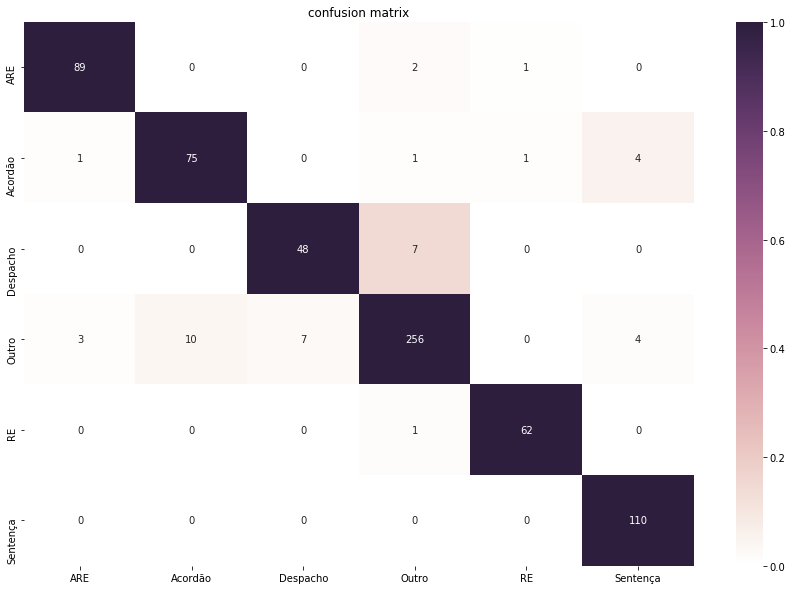

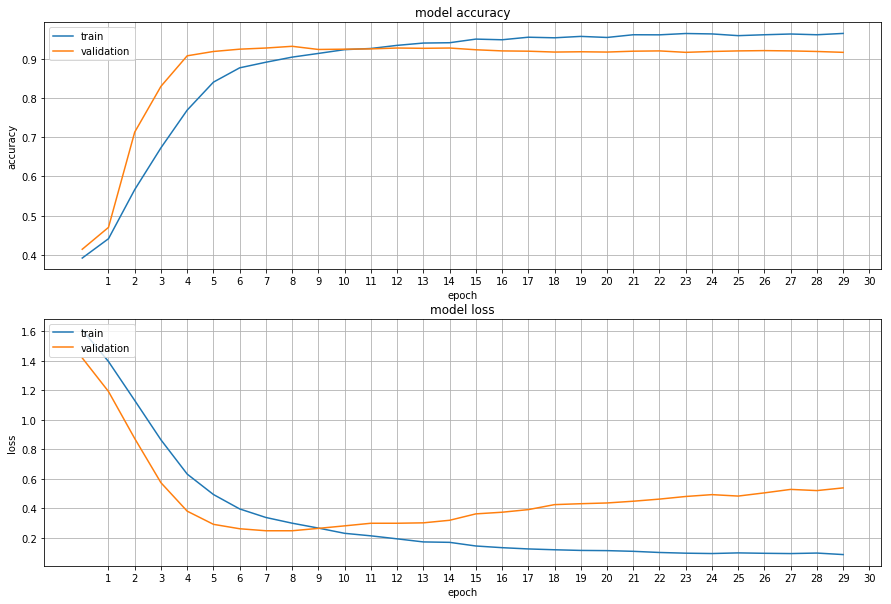

8 [0.39211574764865625, 0.4413923249539151, 0.5665758011800535, 0.6730970857802815, 0.769133990991788, 0.8404277624337022, 0.8769133986979817, 0.8911721539162419, 0.9041727817291033, 0.9136087238401156, 0.9232543514419287, 0.9261899779092393, 0.9341581047743616, 0.9400293557092463, 0.9408681074961548, 0.9500943596169593, 0.9484168584678228, 0.9549171742490064, 0.953449360802879, 0.957014048167009, 0.9542881109275066, 0.9612078008648733, 0.960998113299346, 0.964353114210302, 0.963304676732619, 0.9589012375065905, 0.9612078001024739, 0.963094988329702, 0.9612078007273915, 0.9645628017758293] [0.4145267791089466, 0.47028613420680265, 0.7131327967038508, 0.8297872347422409, 0.9075568581624497, 0.9185619965600162, 0.9244314027637222, 0.9273661056250574, 0.9317681599170604, 0.9236977270483884, 0.9244314027637222, 0.9251650784790559, 0.9273661051440222, 0.9266324294286883, 0.9273661051440222, 0.9229640481844599, 0.9200293462851952, 0.9192956696077907, 0.9170946434238599, 0.9178283181771232, 0

In [92]:
model = load_model('model-embe-stc-cnn-dense')
pred = model.predict(X_test, verbose=1)
report(Y_test, pred, label_binarizer, history)

### Save model

Save the model in path of models

In [83]:
# save_model(model, 'model-embe-sent_conv-dense.h5')

# Mixed architectures

## Bi-LSTM-Convolutional

LAI, S. et al. Recurrent Convolutional Neural Networks for Text Classification. In:
Proceedings of the Twenty-Ninth AAAI Conference on Artificial Intelligence. Austin,
Texas: AAAI Press, 2015. (AAAI’15), p. 2267–2273. ISBN 978-0-262-51129-2. Disponível
em: <http://dl.acm.org/citation.cfm?id=2886521.2886636>.

In [84]:
model = Sequential()
model.add(Embedding(MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN))

model.add(Bidirectional(CuDNNLSTM(units=UNITS, return_sequences=True), merge_mode='concat'))  # Use CuDNNLSTM to use in GPU
# model.add(Reshape(target_shape=(UNITS//2, 2)))

# model.add(Conv1D(kernel_size=4, filters=256, activation='relu', ))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(NB_CLASS, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 1000, 100)         7000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1000, 200)         161600    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 500, 200)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 100000)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 600006    
Total params: 7,761,606
Trainable params: 7,761,606
Non-trainable params: 0
_________________________________________________________________


### Train

In [85]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_validation, Y_validation),
    epochs=EPOCHS,
    callbacks=get_checkpoint('model-bilstm-pooling.h5'),
    batch_size=BATCH_SIZE,
)

Train on 4769 samples, validate on 1363 samples
Epoch 1/30
4769/4769 [==============================] - 12s 2ms/step - loss: 1.3793 - acc: 0.4642 - val_loss: 0.9720 - val_acc: 0.6398

Epoch 00001: val_acc improved from -inf to 0.63977, saving model to /home/seth/marcelo/tcc/models/model-bilstm-pooling.h5
Epoch 2/30
4769/4769 [==============================] - 3s 606us/step - loss: 0.5721 - acc: 0.8073 - val_loss: 0.4402 - val_acc: 0.8584

Epoch 00002: val_acc improved from 0.63977 to 0.85840, saving model to /home/seth/marcelo/tcc/models/model-bilstm-pooling.h5
Epoch 3/30
4769/4769 [==============================] - 3s 609us/step - loss: 0.2260 - acc: 0.9295 - val_loss: 0.3216 - val_acc: 0.9017

Epoch 00003: val_acc improved from 0.85840 to 0.90169, saving model to /home/seth/marcelo/tcc/models/model-bilstm-pooling.h5
Epoch 4/30
4769/4769 [==============================] - 3s 609us/step - loss: 0.1202 - acc: 0.9660 - val_loss: 0.3277 - val_acc: 0.9134

Epoch 00004: val_acc improved fro

### Report

682/682 [==============================] - 5s 7ms/step
              precision    recall  f1-score   support

         ARE       0.97      0.97      0.97        92
     Acordão       0.83      0.79      0.81        82
    Despacho       0.86      0.89      0.88        55
       Outro       0.92      0.90      0.91       280
          RE       0.98      0.98      0.98        63
    Sentença       0.92      0.98      0.95       110

   micro avg       0.92      0.92      0.92       682
   macro avg       0.91      0.92      0.92       682
weighted avg       0.92      0.92      0.92       682

Accuracy:  0.9178885630498533


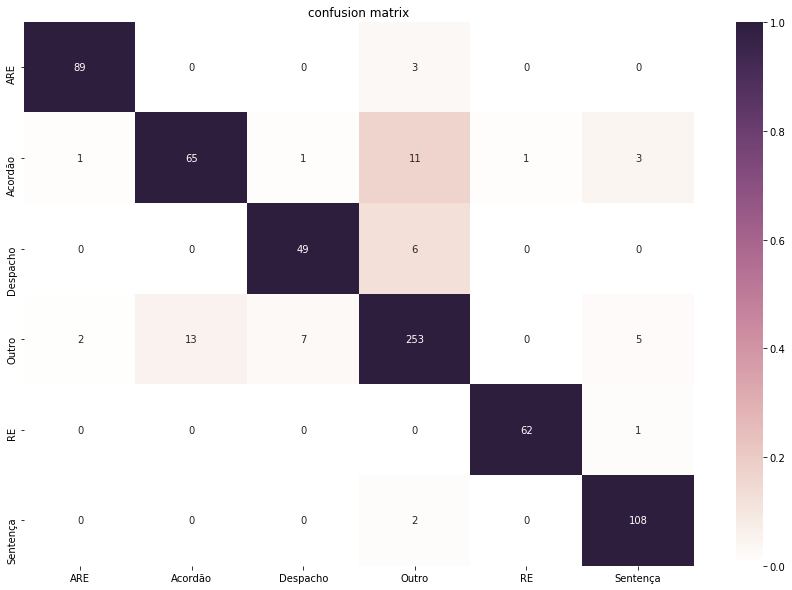

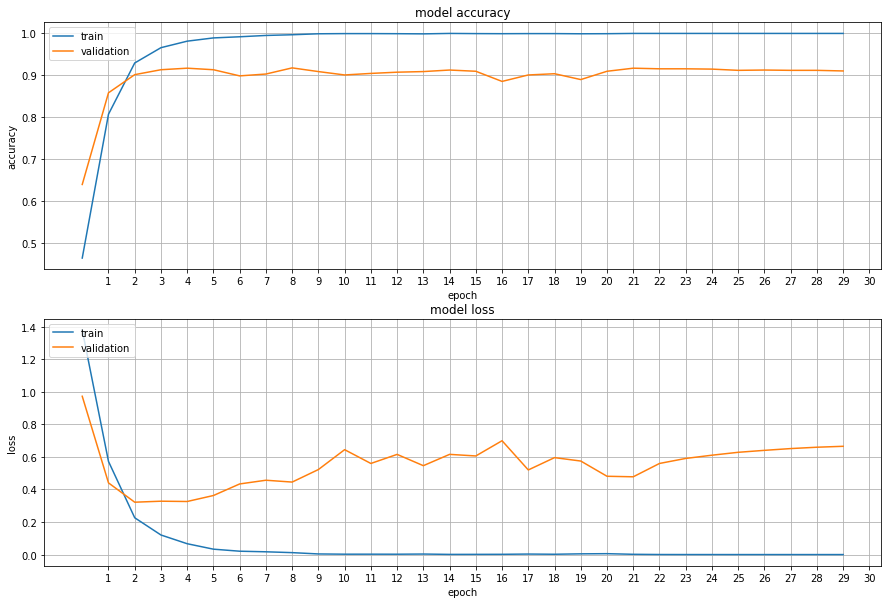

8 [0.4642482701775712, 0.8072971269428968, 0.9295449781952776, 0.9660306148720027, 0.9815474948585096, 0.9893059347830221, 0.9920318717475607, 0.9951771859928706, 0.9968546871420072, 0.9991612497378906, 0.999580625493863, 0.9995806248689453, 0.9993709373034179, 0.9989515621723631, 1.0, 0.9995806248689453, 0.9993709373034179, 0.9995806248689453, 0.9995806248689453, 0.9991612497378906, 0.9993709373034179, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [0.6397652222405263, 0.8584005864158065, 0.9016874543639202, 0.9134262648471908, 0.9170946456103839, 0.9134262638851203, 0.8987527495784438, 0.9031548070190413, 0.9178283181771232, 0.9090242110362231, 0.9009537798730398, 0.9046221557821497, 0.9075568581624497, 0.9090242095931172, 0.9126925881697864, 0.9097578853084511, 0.8855465871834702, 0.9009537781675511, 0.9038884822533398, 0.8899486414754731, 0.9097578879760104, 0.9170946434238599, 0.9156272941797162, 0.9156272941797162, 0.9148936153157878, 0.9119589124544526, 0.9126925881697864, 0.91195

In [86]:
model = load_model('model-bilstm-pooling')
pred = model.predict(X_test, verbose=1)
report(Y_test, pred, label_binarizer, history)

## Convolutional LSTM

ZHOU, C. et al. A C-LSTM Neural Network for Text Classification. nov. 2015. Disponível
em: <https://arxiv.org/abs/1511.08630>.

In [87]:
model = Sequential()
model.add(Embedding(MAX_FEATURES, output_dim=EMBEDDING_OUT, input_length=SEQUENCE_LEN))

model.add(Conv1D(kernel_size=2, filters=128, activation='relu', padding='same'))
# model.add(MaxPooling1D(pool_size=2))

model.add(CuDNNLSTM(units=UNITS * 2, return_sequences=True, ))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(NB_CLASS, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 1000, 100)         7000000   
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 1000, 128)         25728     
_________________________________________________________________
cu_dnnlstm_4 (CuDNNLSTM)     (None, 1000, 200)         264000    
_________________________________________________________________
dropout_8 (Dropout)          (None, 1000, 200)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 200000)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 6)                 1200006   
Total params: 8,489,734
Trainable params: 8,489,734
Non-trainable params: 0
_________________________________________________________________


### Train

In [88]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_validation, Y_validation),
    epochs=EPOCHS,
    callbacks=get_checkpoint('model-cnn-lstm.h5'),
    batch_size=BATCH_SIZE,
)

Train on 4769 samples, validate on 1363 samples
Epoch 1/30
4769/4769 [==============================] - 13s 3ms/step - loss: 1.4589 - acc: 0.4250 - val_loss: 1.1867 - val_acc: 0.5840

Epoch 00001: val_acc improved from -inf to 0.58401, saving model to /home/seth/marcelo/tcc/models/model-cnn-lstm.h5
Epoch 2/30
4769/4769 [==============================] - 3s 654us/step - loss: 0.7966 - acc: 0.7113 - val_loss: 0.6087 - val_acc: 0.8371

Epoch 00002: val_acc improved from 0.58401 to 0.83712, saving model to /home/seth/marcelo/tcc/models/model-cnn-lstm.h5
Epoch 3/30
4769/4769 [==============================] - 3s 656us/step - loss: 0.2954 - acc: 0.9117 - val_loss: 0.3410 - val_acc: 0.8907

Epoch 00003: val_acc improved from 0.83712 to 0.89068, saving model to /home/seth/marcelo/tcc/models/model-cnn-lstm.h5
Epoch 4/30
4769/4769 [==============================] - 3s 658us/step - loss: 0.1259 - acc: 0.9620 - val_loss: 0.3512 - val_acc: 0.9083

Epoch 00004: val_acc improved from 0.89068 to 0.908

### Report

682/682 [==============================] - 6s 8ms/step
              precision    recall  f1-score   support

         ARE       0.94      0.98      0.96        92
     Acordão       0.88      0.87      0.87        82
    Despacho       0.87      0.87      0.87        55
       Outro       0.93      0.92      0.92       280
          RE       0.97      0.92      0.94        63
    Sentença       0.92      0.95      0.93       110

   micro avg       0.92      0.92      0.92       682
   macro avg       0.92      0.92      0.92       682
weighted avg       0.92      0.92      0.92       682

Accuracy:  0.9208211143695014


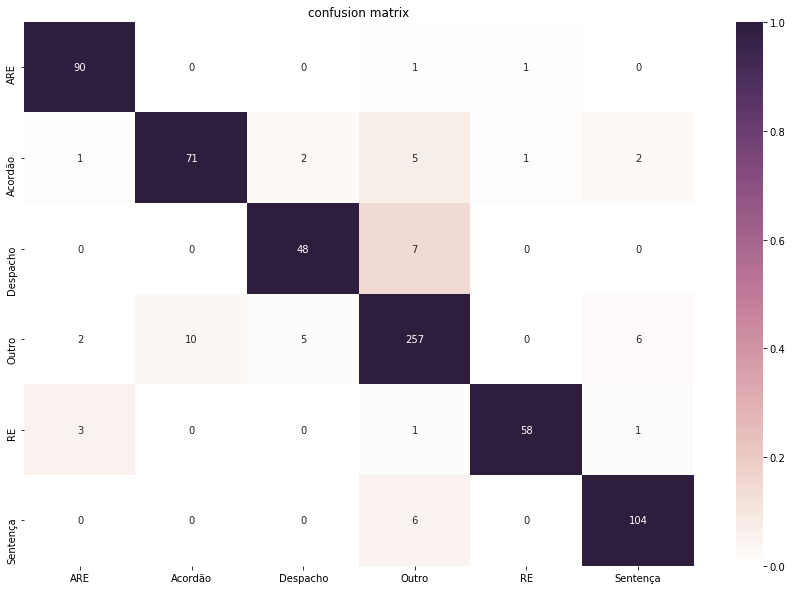

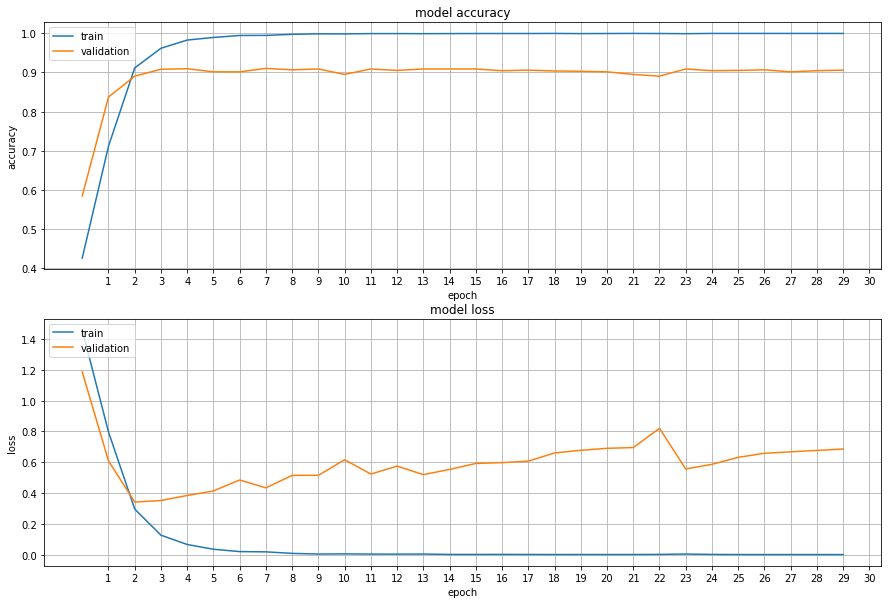

7 [0.425036695773908, 0.711260221931364, 0.9117215354754056, 0.9620465497396656, 0.9830153070548017, 0.9897253099140768, 0.9947578100994163, 0.9949674984273432, 0.997693436779199, 0.9989515621723631, 0.9987418746068358, 0.9995806248689453, 0.9995806248689453, 0.9993709373034179, 0.9995806248689453, 0.9997903124344726, 0.9997903124344726, 0.9997903124344726, 1.0, 0.9995806248689453, 0.9997903130593903, 1.0, 0.9997903124344726, 0.9993709373034179, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] [0.5840058695806446, 0.837123991152161, 0.890682317190807, 0.9082905360643074, 0.9097578862705217, 0.9016874524397791, 0.9016874524397791, 0.9104915619858555, 0.9068231855957104, 0.9090242127417119, 0.8950843724448805, 0.9090242127417119, 0.9053558341650427, 0.9090242110362231, 0.9090242127417119, 0.9090242127417119, 0.904622158449709, 0.9060895098803766, 0.9038884800668158, 0.9031548038704467, 0.9016874529208143, 0.8950843710017746, 0.890682317190807, 0.9090242127417119, 0.904622158449709, 0.9053558341650427, 0.90

In [89]:
model = load_model('model-cnn-lstm')
pred = model.predict(X_test, verbose=1)
report(Y_test, pred, label_binarizer, history)